In [1]:
import pandas as pd
import numpy as np
import os
import warnings
import gc
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [3]:
def generateUserFeatures(df):
    user_base_features = df.groupby("user_id").agg(
        total_orders = ("order_number", "max"), ## app liking
        avg_time_between_orders = ("days_since_prior_order", "mean"), ## app loyalty
        usual_buying_time = ("order_hour_of_day", "median"), ## buying pattern
        usual_buying_day = ("order_dow", "median"), ## buying pattern
        total_unique_products_bought = ("product_id", "nunique"), ## new product recommendation
    ).reset_index()

    first_product_reordered = df[((df.cart_order == 1) & (df.order_number != 1))].groupby("user_id")["reordered"].mean().reset_index(name="first_product_reordered")
    user_base_features = user_base_features.merge(first_product_reordered, on="user_id", how="left")

    temp = df[df.order_number != 1].groupby(["user_id", "order_id"])["reordered"].sum().reset_index()
    temp["complete_new_order"] = (temp["reordered"] == 0).astype(int)
    new_order = temp.groupby("user_id")["complete_new_order"].mean().reset_index()
    user_base_features = user_base_features.merge(new_order, on="user_id", how="left")

    user_order_features = df[df.order_number != 1].groupby(["user_id", "order_number"]).agg(
        product_per_order = ("product_id", "count"), ## buying nature
        reorder_ratio_per_order = ("reordered", "mean"),  ## buying nature
    ).reset_index()

    user_order_features = user_order_features.groupby("user_id").agg(
        average_product_per_order = ("product_per_order", "median"), ## buying nature
        average_reorder_ratio_per_order = ("reorder_ratio_per_order", "mean"), ## buying nature
    ).reset_index()

    user_features = user_base_features.merge(user_order_features, on="user_id", how="left")

    del user_order_features, temp, new_order, first_product_reordered, user_base_features
    gc.collect()
    user_features.columns = [col + "_user" if col != "user_id" else col for col in user_features.columns]
    return user_features

def generateProductFeatures(df):
    product_base_features = df.groupby("product_id").agg(
        reorder_ratio = ("reordered", "mean"), ## Product popularity
        total_purchases = ("order_id", "count"), ## Overall interest
        usual_position_in_cart = ("cart_order", "median"), ## Type of product [Needs/Wants/Last minute impulse]
        avg_cart_size = ("cart_size", "mean"), ## Part of staple order or not
        usual_buying_time = ("order_hour_of_day", "median"), ## buying pattern
        usual_buying_day = ("order_dow", "median"), ## buying pattern
    ).reset_index()

    user_product_base_features = df.groupby(["user_id", "product_id"]).agg(
        total_orders = ("order_id", "nunique"), ## Staple/single shots
        usual_cart_position = ("cart_order", "median")).reset_index() ## User's view on this product (Need/Want),
    
    single_order_ratio = (user_product_base_features[user_product_base_features['total_orders'] == 1].groupby('product_id').size() / user_product_base_features.groupby('product_id').size()).reset_index(name="one_shot_ratio")
    unique_users = user_product_base_features.groupby('product_id').size().reset_index(name="unique_users")
    product_features = product_base_features.merge(single_order_ratio, on="product_id", how="left")
    product_features = product_features.merge(unique_users, on="product_id", how="left")
    product_features.columns = [col+"_product" if col != "product_id" else col for col in product_features.columns if col]

    del product_base_features, single_order_ratio, unique_users
    gc.collect()
    return product_features

def generateUXPFeatures(df):
    user_product_features = df.groupby(["user_id", "product_id"]).agg(
        total_orders = ("order_id", "nunique"), ## Staple/single shots
        usual_cart_position = ("cart_order", "median"), ## User's view on this product (Need/Want),

        ### Reorder chances within n orders
        streak_chance = ("streak", "mean"),
        item_n2_chance = ("item_in_every_2_order", "mean"),
        item_n3_chance = ("item_in_every_3_order", "mean"),
        item_n4_chance = ("item_in_every_4_order", "mean"),
        item_n5_chance = ("item_in_every_5_order", "mean"),
        
        average_reorder_time = ("days_since_prev_order_item", "median")).reset_index() 
    
    user_product_features.columns = [col+"_uxp" if ((col != "user_id") & (col != "product_id")) else col for col in user_product_features.columns if col]
    gc.collect()
    return user_product_features

def generatePriorsTrainTest(priorStart = 0, priorEnd = -3, train=-2, test=-1):
    df = pd.read_csv("../Dataset/TrainingDataset.csv", index_col=0)
    meta_data = pd.read_csv("../Dataset/Metadata.csv", index_col=0)

    max_onb = df.groupby("user_id")["order_number"].max().reset_index(name="max_onb")
    df = df.merge(max_onb, on="user_id")
    df["prior"] = df["max_onb"] + priorEnd
    df["train"] = df["max_onb"] + train
    df["test"] = df["max_onb"] + test
    priors = df[df.order_number < df.prior]
    train = df[df.order_number == df.train]
    test = df[df.order_number == df.test]

    return priors, train, test

def calculateBaseFeatures(df):
    order_features = df.groupby("order_id").agg(
        cart_size = ("product_id", "count"), 
        reorder_ratio = ("reordered", "mean"),
    ).reset_index()

    df = df.merge(order_features, left_on="order_id", right_on="order_id")

    ## User - Product usage (Days since last order of this item by this user)
    df["last_order_number"] = df.groupby(['user_id', 'product_id'])["order_number"].shift(1)

    temp = df.drop_duplicates(subset=["user_id", "order_number"])[["user_id", "order_number", "days_since_prior_order"]]
    temp["days_since_first_order"] = temp.groupby(["user_id"])["days_since_prior_order"].cumsum()
    temp["last_order_number"] = temp["order_number"]

    df = df.merge(temp[["user_id", "order_number", "days_since_first_order"]], left_on=["user_id", "order_number"], right_on=["user_id", "order_number"], how="left")
    df = df.rename(columns={"days_since_first_order": "curr_order_days_since_first_order"})

    df = df.merge(temp[["user_id", "last_order_number", "days_since_first_order"]], left_on=["user_id", "last_order_number"], right_on=["user_id", "last_order_number"], how="left")
    df = df.rename(columns={"days_since_first_order": "prev_order_days_since_first_order"})

    df["curr_order_days_since_first_order"] = df["curr_order_days_since_first_order"].fillna(0)
    df["prev_order_days_since_first_order"] = df["reordered"]*(df["last_order_number"]/df["last_order_number"])*df["prev_order_days_since_first_order"].fillna(0)
    df.loc[:,"days_since_prev_order_item"] = df["curr_order_days_since_first_order"] - df["prev_order_days_since_first_order"]

    df = df.drop(["curr_order_days_since_first_order", "prev_order_days_since_first_order"], axis=1)

    df["last_order_number"] = df.groupby(['user_id', 'product_id'])["order_number"].shift(1)

    df["streak"] = ((df["order_number"] - df["last_order_number"]) == 1).astype(int)
    df["item_in_every_2_order"] = ((df["order_number"] - df["last_order_number"]) == 2).astype(int)
    df["item_in_every_3_order"] = ((df["order_number"] - df["last_order_number"]) == 3).astype(int)
    df["item_in_every_4_order"] = ((df["order_number"] - df["last_order_number"]) == 4).astype(int)
    df["item_in_every_5_order"] = ((df["order_number"] - df["last_order_number"]) == 4).astype(int)
    del temp, order_features
    gc.collect()

    return df

def generateTrainingDataset(train, productFeatures, userFeatures, uxpFeatures):
    trainingDf = train.merge(uxpFeatures, on=["user_id", "product_id"], how="left")
    trainingDf = trainingDf.merge(userFeatures, on="user_id", how="left")
    trainingDf = trainingDf.merge(productFeatures, on="product_id", how="left")
    trainingDf.fillna(0, inplace=True)
    
    return trainingDf

def dummyTraining(trainingDf, testDf=None):
    features = ['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 
            'total_orders_uxp', 'usual_cart_position_uxp', 'streak_chance_uxp', 'item_n2_chance_uxp', 
            'item_n3_chance_uxp', 'item_n4_chance_uxp', 'item_n5_chance_uxp', 
            'average_reorder_time_uxp', 
            'reorder_ratio_product', 'total_purchases_product', 'usual_position_in_cart_product', 'avg_cart_size_product', 
            'usual_buying_time_product', 'usual_buying_day_product', 'one_shot_ratio_product', 'unique_users_product', 
            'total_orders_user', 'avg_time_between_orders_user', 'usual_buying_time_user', 'usual_buying_day_user', 
            'total_unique_products_bought_user', 'first_product_reordered_user', 'complete_new_order_user',
            'average_product_per_order_user', 'average_reorder_ratio_per_order_user']
    X = trainingDf[features]
    y = trainingDf["reordered"]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert the dataset into a DMatrix object, which is a data structure that XGBoost uses for optimized data handling
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X, label=y)

    # Set the parameters for the XGBoost model
    params = {
        'max_depth': 3, 
        'eta': 0.1, 
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
    }

    # Train the XGBoost model
    num_round = 100
    bst = xgb.train(params, dtrain, num_round)

    # Make predictions on the test set
    y_pred_prob = bst.predict(dtest)
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)

    # Evaluate the model
    accuracy = accuracy_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    class_report = classification_report(y, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)


    importance_scores = bst.get_score(importance_type='weight')
    # Convert the scores into a DataFrame for better readability
    importance_df = pd.DataFrame({
        'Feature': list(importance_scores.keys()),
        'Importance': list(importance_scores.values())
    }).sort_values(by='Importance', ascending=False)

    # Display the feature importance DataFrame
    print(importance_df)

    # Plot the feature importance
    plt.figure(figsize=(10, 8))
    xgb.plot_importance(bst, importance_type='weight')
    plt.title('Feature Importance')
    plt.show()

In [4]:
priors, train, test = generatePriorsTrainTest()

In [5]:
featureDf = calculateBaseFeatures(priors)

In [6]:
productFeatures = generateProductFeatures(featureDf)
userFeatures = generateUserFeatures(featureDf)
uxpFeatures = generateUXPFeatures(featureDf)

In [7]:
trainingDf = generateTrainingDataset(train, productFeatures, userFeatures, uxpFeatures)

Accuracy: 0.9312
Confusion Matrix:
[[1019197    1531]
 [ 142660  931099]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93   1020728
           1       1.00      0.87      0.93   1073759

    accuracy                           0.93   2094487
   macro avg       0.94      0.93      0.93   2094487
weighted avg       0.94      0.93      0.93   2094487

                                 Feature  Importance
0                           order_number       105.0
3                       total_orders_uxp        82.0
2                 days_since_prior_order        70.0
4                  reorder_ratio_product        42.0
7                 one_shot_ratio_product        20.0
6         usual_position_in_cart_product        14.0
11     total_unique_products_bought_user        14.0
8                   unique_users_product        11.0
13               complete_new_order_user        11.0
14        average_product_per_order_user      

<Figure size 1000x800 with 0 Axes>

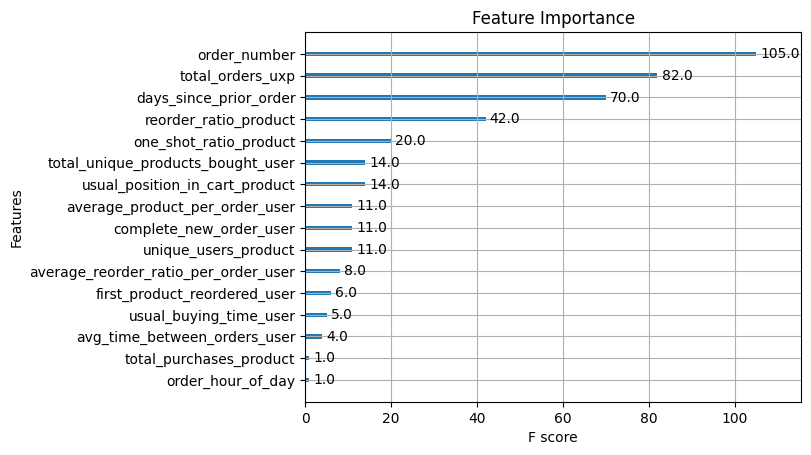

In [8]:
dummyTraining(trainingDf)

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("../OriginalDataset/orders.csv")

In [4]:
data[data.eval_set == "test"]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0
...,...,...,...,...,...,...,...
3420918,2728930,206202,test,23,2,17,6.0
3420929,350108,206204,test,5,4,14,14.0
3421001,1043943,206206,test,68,0,20,0.0
3421018,2821651,206207,test,17,2,13,14.0
